In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random

#### Set Hyperparameters

In [153]:
BATCH_SIZE = 32
TRAIN_SIZE = 10000
VALID_SIZE = 1000
LR = 1e-4
EPOCH = 3000

In [112]:
dataset = torchvision.datasets.MNIST(root="data/mnist",
                                     train=True,
                                     transform=torchvision.transforms.ToTensor(),
                                     download=False)
validset = torchvision.datasets.MNIST(root="data/mnist",
                                     train=False,)

#### Some Helper Function

In [159]:
def random_data(data, label, size, CNN=True):
    train_data = data[:size]
    if CNN:
        train_data = train_data.unsqueeze(1) # make the channel
    else:
        train_data = train_data.view(-1, 28*28)
    train_data = train_data.type(torch.FloatTensor)/255.
    train_labels = label[:size]
    random.shuffle(train_labels)
    train_data = Variable(train_data)
    train_labels = Variable(train_labels)
    return train_data, train_labels

def make_batch(data, batch_size):
    batch_data = []
    for i in range(data.shape[0]//batch_size):
        if batch_size * (i+1) < data.shape[0]:
            batch_data.append(data[batch_size * i:batch_size * (i+1)])
        else:
            batch_data.append(data[batch_size * i:])
    return batch_data

In [160]:
train_data, train_labels = random_data(dataset.train_data, dataset.train_labels, TRAIN_SIZE, CNN=False)
valid_data, valid_labels = random_data(validset.test_data, validset.test_labels, VALID_SIZE, CNN=False)

[2, 0, 2, 8, 9]


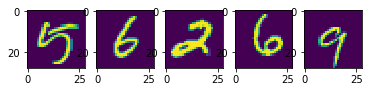

In [120]:
# test
num_sample = 5
samples = random.sample(list(range(TRAIN_SIZE)), num_sample)
print([train_labels[sample] for sample in samples])
fig, axes = plt.subplots(1,num_sample)
for sample, ax in zip(samples, axes):
    ax.imshow(train_data.numpy()[sample][0])

In [161]:
train_data = make_batch(train_data, BATCH_SIZE)
train_labels = make_batch(train_labels, BATCH_SIZE)

In [162]:
# test
print("input shape: ", train_data[0].shape)
print("label shape: ", train_labels[0].shape)
print("number of batchs:", len(train_data), len(train_labels))

input shape:  torch.Size([32, 784])
label shape:  torch.Size([32])
number of batchs: 312 312


In [163]:
class CNN(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   nn.BatchNorm2d(16))
                                   # m * 16 * 14 * 14
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),
                                   nn.BatchNorm2d(32))
                                   # m * 32 * 7 * 7
        self.fc1 = nn.Linear(32 * 7 * 7, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [164]:
model = FC()
optimizer = optim.Adam(params=model.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [165]:
train_loss = []
test_loss = []
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(zip(train_data, train_labels)):
        pred = model(x)
        optimizer.zero_grad()
        loss = loss_func(pred, y)
        loss.backward()
        optimizer.step()
    if epoch % 500 == 0:
        print("epoch: %d | loss: %.4f" % (epoch, loss.data[0]))
    
    pred_ = model(valid_data)
    loss_ = loss_func(pred_, valid_labels)
    train_loss.append(loss.data[0])
    test_loss.append(loss_.data[0])

epoch: 0 | loss: 2.3058
epoch: 500 | loss: 0.8616
epoch: 1000 | loss: 0.2630
epoch: 1500 | loss: 0.1374
epoch: 2000 | loss: 0.2795
epoch: 2500 | loss: 1.1111


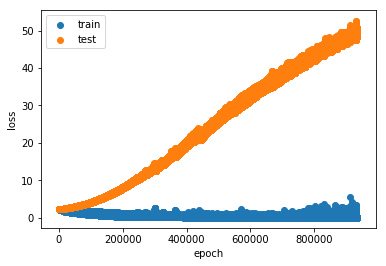

In [167]:
plt.scatter(np.arange(EPOCH * 312), train_loss, label='train')
plt.scatter(np.arange(EPOCH * 312), test_loss, label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()